In [ ]:
!pip install tflite
!pip install tensorflowjs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras

# Load Dataset

In [2]:
(ds_train, ds_validation, ds_test), metadata  = tfds.load(
    "tf_flowers", 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    as_supervised=True, 
    with_info=True
)

In [ ]:
metadata

In [3]:
print(metadata.splits["train"].num_examples)
num_classes = metadata.features["label"].num_classes
labels = metadata.features["label"].names
print(num_classes)
print(labels)

3670
5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


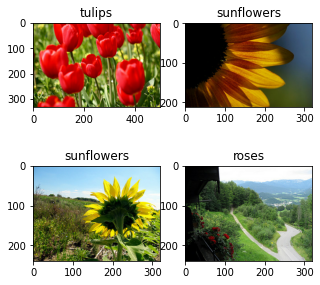

In [4]:
samples = ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    img_array, img_label_idx = img
    #print(np.min(img_array), np.max(img_array))
    ax = fig.add_subplot(2,2, i + 1)    
    ax.imshow(img_array)    
    ax.set_title(labels[img_label_idx])
plt.show()

In [5]:
IMG_SIZE = 150

resize_and_rescale = Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1)
])


def prepare_for_training(ds_subset, batch_size = 32, shuffle=False, augment=False):
    ds_subset  =  ds_subset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        ds_subset = ds_subset.shuffle(1000)
    
    # create data batches
    ds_subset = ds_subset.batch(batch_size)

    # apply data augmentation
    if augment:        
        ds_subset= ds_subset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


transformed_ds_train = prepare_for_training(ds_train, shuffle=True, augment=True)
transformed_ds_val = prepare_for_training(ds_validation)
transformed_ds_test = prepare_for_training(ds_test)

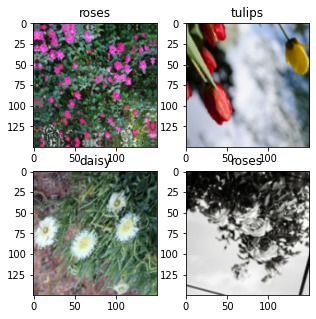

In [13]:
samples = transformed_ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    batch_images, batch_labels = img
    #print(np.min(img_array), np.max(img_array))
    ax = fig.add_subplot(2,2, i + 1)    
    ax.imshow(batch_images[0])    
    ax.set_title(labels[batch_labels[0]])
plt.show()

In [6]:
from tensorflow import keras

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [7]:
base_model.trainable = False

In [10]:
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

In [11]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [12]:
epochs=5
history = model.fit(transformed_ds_train,validation_data=transformed_ds_val, epochs=epochs, batch_size=32)

Epoch 1/5
92/92 [==============================] - 24s 175ms/step - loss: 0.9984 - accuracy: 0.6267 - val_loss: 0.6298 - val_accuracy: 0.7602
Epoch 2/5
92/92 [==============================] - 12s 128ms/step - loss: 0.6444 - accuracy: 0.7772 - val_loss: 0.5653 - val_accuracy: 0.7738
Epoch 3/5
92/92 [==============================] - 12s 129ms/step - loss: 0.5721 - accuracy: 0.7977 - val_loss: 0.5781 - val_accuracy: 0.8065
Epoch 4/5
92/92 [==============================] - 12s 129ms/step - loss: 0.5249 - accuracy: 0.8093 - val_loss: 0.5129 - val_accuracy: 0.8392
Epoch 5/5
92/92 [==============================] - 12s 128ms/step - loss: 0.5071 - accuracy: 0.8287 - val_loss: 0.6190 - val_accuracy: 0.7766


In [ ]:
out_folder = "trained_model"
model.save(out_folder)

In [ ]:
loaded_model = tf.keras.models.load_model(out_folder)

In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(loaded_model, out_folder)

In [ ]:
image_url = "https://static.wixstatic.com/media/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg/v1/fill/w_1000,h_666,al_c,q_90,usm_0.66_1.00_0.01/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg"
image_path = tf.keras.utils.get_file("image_test", image_url)

In [ ]:
img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

In [ ]:
plt.imshow(img)

In [ ]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = tf.convert_to_tensor(img_array)
img_tensor = tf.expand_dims(img_tensor, 0) 
img_tensor = tf.divide(img_tensor, 255.0)
scores = loaded_model(img_tensor)
probs = tf.nn.softmax(scores).numpy().squeeze()
class_idx = np.argmax(probs)
print(f"this image was classified as {labels[class_idx]} with a probability of {probs[class_idx]}")

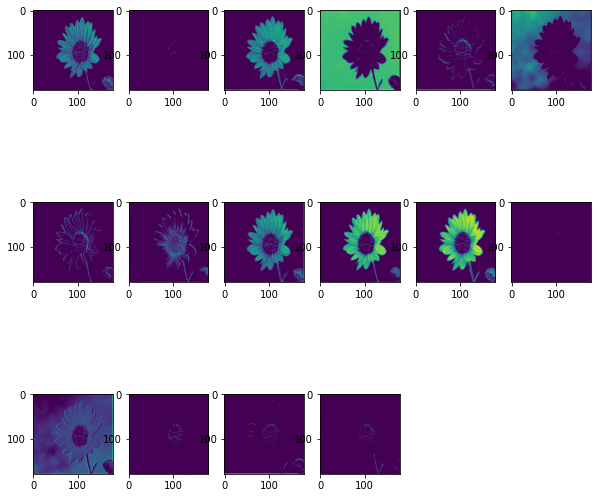

In [ ]:
import math
cnn_layers = [layer for layer in loaded_model.layers  if isinstance(layer, layers.Conv2D)]        
cnn_layers = cnn_layers[:1]
features_extraction_model = Sequential(cnn_layers)
features_map = features_extraction_model(img_tensor).numpy().squeeze()
num_fmaps = features_map.shape[-1]
num_rows = math.ceil(num_fmaps / 6)
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(num_rows, 6, i + 1)
    ax.imshow(fmap)
plt.show()

In [ ]:
cnn_layer  = loaded_model.get_layer("conv2d")

In [ ]:
features_map = cnn_layer(img_tensor)
features_map = features_map.numpy().squeeze()
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(4,4, i + 1)
    ax.imshow(fmap)
plt.show()

In [ ]:
!zip -r /content/model.zip /content/trained_model

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/assets/ (stored 0%)
  adding: content/trained_model/saved_model.pb (deflated 89%)
  adding: content/trained_model/group1-shard3of4.bin (deflated 7%)
  adding: content/trained_model/group1-shard1of4.bin (deflated 7%)
  adding: content/trained_model/variables/ (stored 0%)
  adding: content/trained_model/variables/variables.index (deflated 65%)
  adding: content/trained_model/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/trained_model/model.json (deflated 81%)
  adding: content/trained_model/group1-shard4of4.bin (deflated 7%)
  adding: content/trained_model/group1-shard2of4.bin (deflated 7%)


In [ ]:
from google.colab import files
files.download("/content/model.zip")